In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import imageio
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
data = pd.read_csv('/content/metro_station_peak_hour_data (2).csv')
data.head()

,Time Interval,Day,SpecialEvent,Weather,People Count
0,01-01-2024 00:00,Monday,False,Rainy,10
1,01-01-2024 00:10,Monday,False,Rainy,14
2,01-01-2024 00:20,Monday,False,Cloudy,11
3,01-01-2024 00:30,Monday,False,Rainy,10
4,01-01-2024 00:40,Monday,False,Sunny,10


In [3]:
# Convert 'Time Interval' to datetime, specifying the correct format
data['Time Interval'] = pd.to_datetime(data['Time Interval'], format='%d-%m-%Y %H:%M', errors='coerce')

In [4]:
# Rename columns for Prophet
data = data.rename(columns={'Time Interval': 'ds', 'People Count': 'y'})

In [5]:
# Drop unnecessary columns (if any)
data = data[['ds', 'y']]

In [6]:
# Check for missing values
print(data.isnull().sum())

ds    0
y     0
dtype: int64


In [7]:
# Sort by time
data = data.sort_values('ds')

# Divide into four parts
n = len(data)
part_size = n // 4
parts = [data.iloc[i*part_size:(i+1)*part_size] for i in range(4)]

# Save the four parts to CSV
for i, part in enumerate(parts):
    part.to_csv(f'part_{i+1}.csv', index=False)

In [8]:
# Function to train Prophet and make predictions
def train_prophet(train_data, test_data):
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    model.fit(train_data)

    # Predict on test data
    future = model.make_future_dataframe(periods=len(test_data), freq='10T')
    forecast = model.predict(future)

    # Merge predictions with actual data
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    results = pd.merge(test_data, forecast, on='ds', how='left')

    return results, model

# Train and predict for each part
predictions = []
for i, part in enumerate(parts):
    train_data = part.iloc[:int(0.8 * len(part))]  # 80% training
    test_data = part.iloc[int(0.8 * len(part)):]   # 20% testing

    results, model = train_prophet(train_data, test_data)
    predictions.append(results)

    # Save predictions to CSV
    results.to_csv(f'predictions_part_{i+1}.csv', index=False)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvq1u46c2/6nl5af6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvq1u46c2/7df4bg9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40741', 'data', 'file=/tmp/tmpvq1u46c2/6nl5af6m.json', 'init=/tmp/tmpvq1u46c2/7df4bg9f.json', 'output', 'file=/tmp/tmpvq1u46c2/prophet_modeldls2cu4r/prophet_model-20250204145741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvq1u46c2/

In [9]:
import plotly.express as px

# Plot predictions vs. actual for each part
for i, pred in enumerate(predictions):
    fig = px.line(pred, x='ds', y=['y', 'yhat'], title=f'Part {i+1}: Predictions vs. Actual')
    fig.update_layout(xaxis_title="Time", yaxis_title="People Count")
    fig.show()

In [10]:
# Function to create a frame for the GIF
def create_frame(data, pred, frame_number):
    plt.figure(figsize=(14, 7))
    plt.plot(data['ds'], data['y'], label='Actual', color='blue')
    plt.plot(pred['ds'][:frame_number], pred['yhat'][:frame_number], label='Predicted', color='red', linestyle='--')
    plt.title(f"Predictions vs. Actual (Part {i+1})")
    plt.xlabel("Time")
    plt.ylabel("People Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'frame_part_{i+1}_{frame_number}.png')
    plt.close()

# Generate frames for each part
for i, pred in enumerate(predictions):
    frames = []
    for frame_number in range(1, len(pred), 10):  # Every 10th frame
        create_frame(parts[i], pred, frame_number)
        frames.append(imageio.imread(f'frame_part_{i+1}_{frame_number}.png'))

    # Save as GIF
    imageio.mimsave(f'predictions_part_{i+1}.gif', frames, duration=0.5)

<ipython-input-10-d37dab5445c5>:19: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Part 1 Heatmap:


<ipython-input-11-a706895ac7e9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-a706895ac7e9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



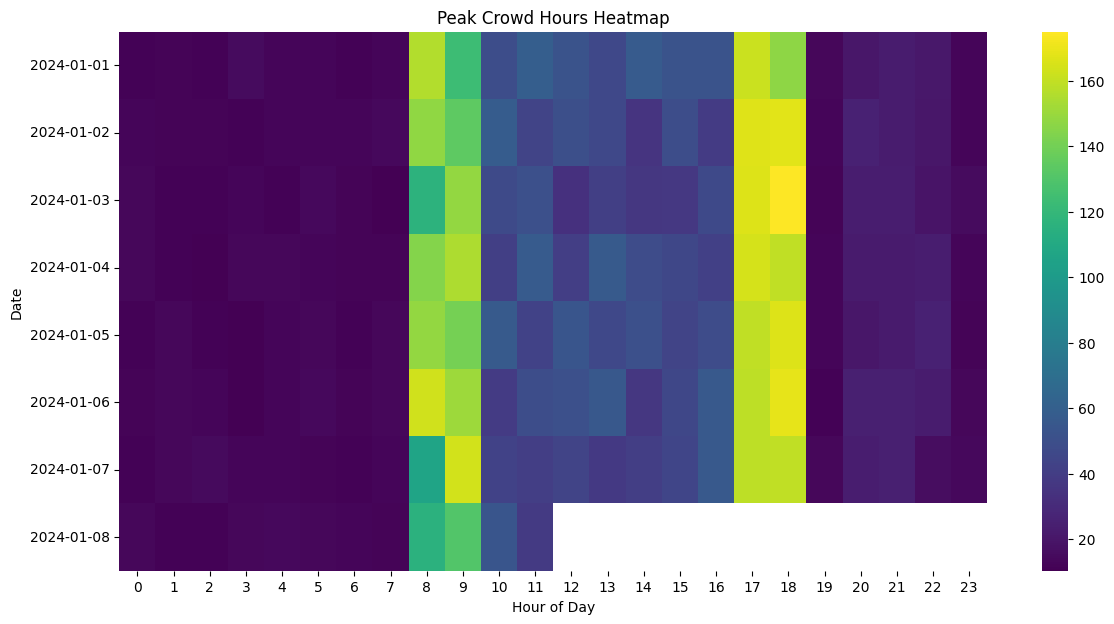

Part 2 Heatmap:


<ipython-input-11-a706895ac7e9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-a706895ac7e9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



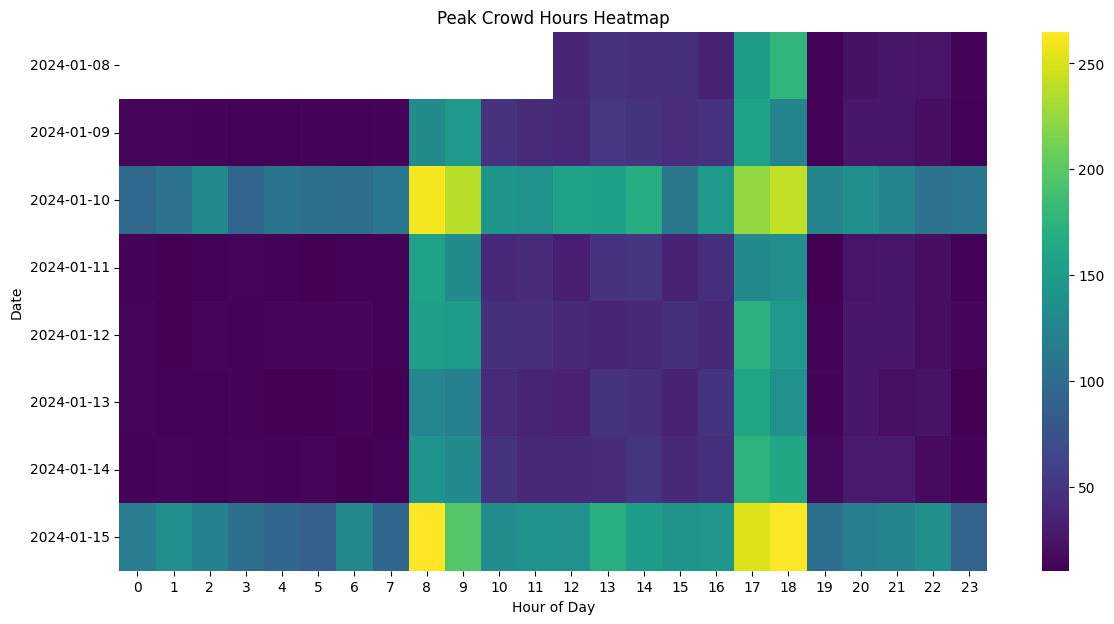

Part 3 Heatmap:


<ipython-input-11-a706895ac7e9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-a706895ac7e9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



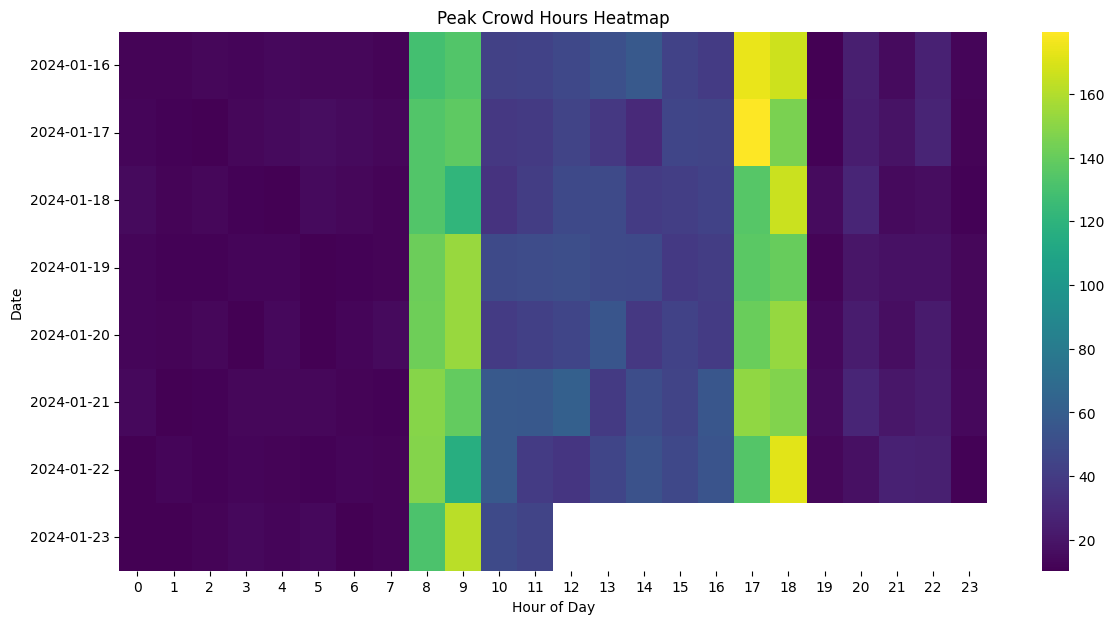

Part 4 Heatmap:


<ipython-input-11-a706895ac7e9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-a706895ac7e9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



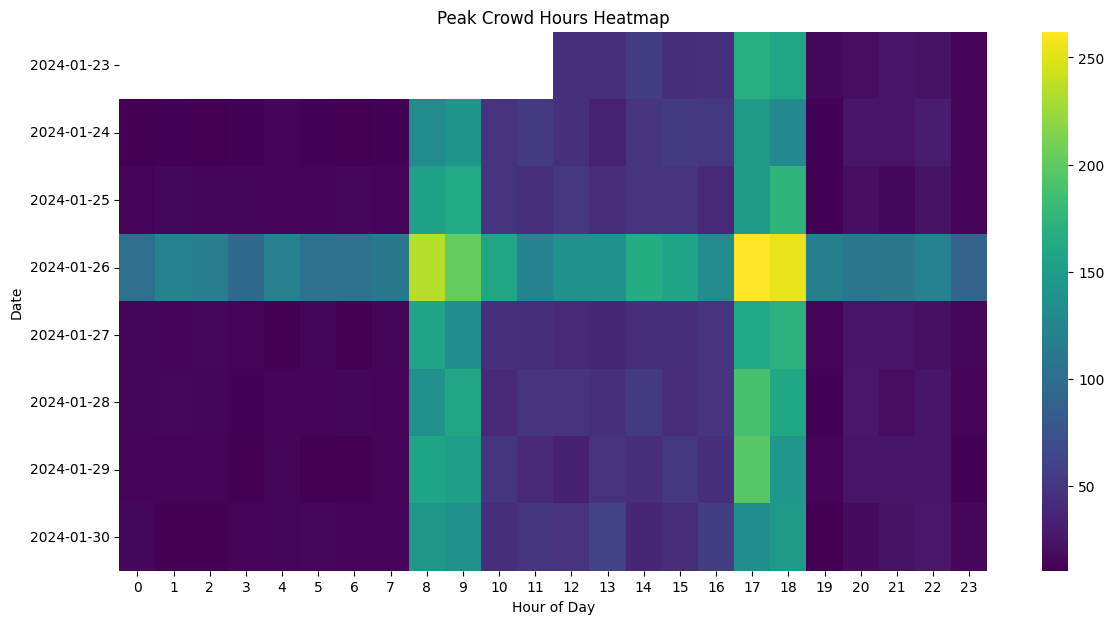

In [11]:
import seaborn as sns

# Function to create heatmap
def create_heatmap(data):
    data['hour'] = data['ds'].dt.hour
    data['date'] = data['ds'].dt.date
    heatmap_data = data.pivot_table(index='date', columns='hour', values='y', aggfunc='mean')

    plt.figure(figsize=(14, 7))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False)
    plt.title("Peak Crowd Hours Heatmap")
    plt.xlabel("Hour of Day")
    plt.ylabel("Date")
    plt.show()

# Create heatmap for each part
for i, part in enumerate(parts):
    print(f"Part {i+1} Heatmap:")
    create_heatmap(part)